In [1]:
import numpy as np
import os
from glob import glob
import pandas as pd
import itertools

from collections import OrderedDict
from tqdm.notebook import tqdm

# import pmi_accuracy.parser as parser
from pmi_accuracy.conll_data import CONLLReader, EXCLUDED_PUNCTUATION, CONLL_COLS
import sys
# print(sys.path)

# Set up

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

def annotate_with_gold(
        im, mat, goldmat, mark="*", 
        textcolors=['black','white'], threshold = 0, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    mat
        pmi matrix
    goldmat
        the matrix showing gold edges (1), or not (0)
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied. Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """
    data = goldmat
    kw = dict(horizontalalignment="center",
          verticalalignment="center")
    kw.update(textkw)
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i,j]:
                kw.update(color=textcolors[int(mat[i, j] > threshold)])
                text = im.axes.text(j, i, mark, **kw)
                texts.append(text)
    return texts

def show_pmi_plot(sent, mat, gold, fig=None, ax=None, title=None):
    mat = np.nan_to_num(mat) # set nan to 0
    if np.min(mat) < 0:
        lim = max(abs(np.min(mat)), abs(np.max(mat)))
        cmap = 'PuOr'
        vmin, vcenter, vmax = -lim, 0, lim
    else:
        lim=np.max(mat)
        cmap = 'Purples'
        vmin, vcenter, vmax = 0, lim/2, lim
    if ax is None:
        fig, ax = plt.subplots()
    cax = ax.matshow(
        mat, cmap=cmap,
        norm=colors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax))
    if gold.any():
        # mark gold cells
        c=plt.get_cmap(cmap)(np.linspace(0, 1, 2))
        annotate_with_gold(
            cax, mat, goldmat=gold, threshold=vcenter, textcolors=[c[1],c[0]],
            mark='•', size=11, fontweight="bold")
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cax, cax=cax1)
    ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(sent))))
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(len(sent))))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(sent))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(sent))
    ax.tick_params(axis="x", labelrotation=40)
    ax.set_xlabel(r'${\bf w}_J$ (masked/unmasked conditioner)', fontsize=13)
    ax.set_ylabel(r'${\bf w}_I$ (target)', fontsize=13)
    ax.yaxis.set_label_position("left")
    ax.xaxis.labelpad = 10
    if title is not None:
        if plt.rcParams.get('text.usetex'):
            title = title.replace("_","\_")
        ax.set_title(title, y=-.2)
    plt.setp(ax.get_xticklabels(), rotation=35,
             ha="left", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=35,
             ha="right", rotation_mode="anchor")
    if ax is None:
        plt.show()
    
def plot_pmi_matrix(key_sen, pmi_matrix, gold=np.zeros((1)), title=None):
    sentence = key_sen.split(' ')[1:]
    show_pmi_plot(sent=sentence, mat=pmi_matrix, gold=gold, title=title)

In [3]:
RESULTS_DIR = "results-clean/"

######
MATRICES = dict()
MODELS = [
    "bart-large",
    "bert-base-cased",
    # "bert-base-uncased_checkpointed",
    # "bert-base-uncased_pad30_2020-08-07-07-28",
    "bert-large-cased",
    "bert-large-uncased",
    "distilbert-base-cased",
    "gpt2",
    "w2v",
    "xlm",
    "xlnet-base-cased",
    "xlnet-large-cased"]
for m in MODELS:
    resultsdir = glob(os.path.join(
        RESULTS_DIR, "contextual_embedding_models",  m + '*/'))[0]
    npzpath = os.path.join(resultsdir, 'pmi_matrices.npz')
    MATRICES[m] = np.load(npzpath)

######  
POS_MATRICES = dict()
POS_MODELS = [
    ["IB_probe/", "IB_xpos_bert-large-cased"],
    ["IB_probe/", "IB_xpos_xlnet-base-cased"],
    ["simple_probe/", "xpos_bert-large-cased"],
    ["simple_probe/", "xpos_xlnet-base-cased"]
]
for pm in POS_MODELS:
    resultsdir = glob(os.path.join(
        RESULTS_DIR, "pos-cpmi", pm[0] + pm[1] + '*/'))[0]
    npzpath = os.path.join(resultsdir, 'pmi_matrices.npz')
    POS_MATRICES[pm[1]] = np.load(npzpath)

#######
LSTM_MATRICES = dict()
LSTM_MODELS = ["lstm", "onlstm", "onlstm_syd"]
for m in LSTM_MODELS:
    resultsdir = glob(os.path.join("lstm-vs-onlstm/",  m))[0]
    npzpath = os.path.join(resultsdir,'pmi_matrices.npz')
    LSTM_MATRICES[m] = np.load(npzpath)

In [4]:
CONNLX_FILE = 'ptb3-wsj-data/ptb3-wsj-dev.conllx'
OBSERVATIONS = CONLLReader(CONLL_COLS).load_conll_dataset(CONNLX_FILE) 

In [270]:
def get_gold_matrix(observations, sentence_index, no_punct=True):
    heads = OBSERVATIONS[sentence_index].head_indices
    upos = OBSERVATIONS[sentence_index].upos_sentence
    g = np.zeros((len(heads),len(heads)),dtype=int)
    for i,h in enumerate(heads):
        h = int(h)-1 # convert to 0-indexing
        if no_punct and (upos[i]=='PUNCT'):
            continue
        if h == -1:  # ignore root edge
            continue
        g[i][h]=1
    return np.tril(g + g.T)

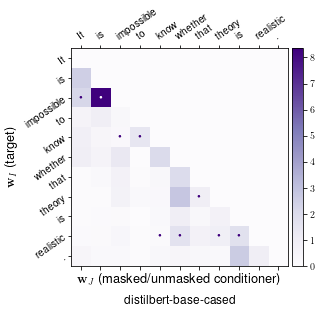

In [314]:
m = 'distilbert-base-cased'
for i in [442]:
    key = list(MATRICES[m].keys())[i]
    mat = MATRICES[m][key]
    if not m == "w2v":
        mat = abs(mat)
    mat = np.nan_to_num(np.tril(mat + mat.T))
    gold=get_gold_matrix(OBSERVATIONS, 442)
#     gold=np.zeros(gold.shape)
    plot_pmi_matrix(key, mat, gold, title=m)
plt.savefig('figures/442distilbert-wgold.pdf', bbox_inches = 'tight')

In [312]:
OUTPUTDIR = "figures/"

def plot_comparison(selected_models, matrices, sentence_indices, observations, save_suffix=None):
    for i in sentence_indices:
        # row of plots for sentence i
        figh = 5
        fig, axs = plt.subplots(
            nrows=1, sharex=True, ncols=len(selected_models),
            figsize=(len(selected_models)*figh,figh))
        for j,m in enumerate(selected_models):
            key = list(matrices[m].keys())[i]
            sentence = key.split(' ')[1:]
            mat = matrices[m][key]
            if m == "w2v":
                np.fill_diagonal(mat, 0)
            else:
                mat = abs(mat)
            mat = np.tril(mat + mat.T)
            gold=get_gold_matrix(observations, i)
            show_pmi_plot(
                sentence, mat, gold, fig=fig, ax=axs[j], 
                title=m)
        plt.subplots_adjust(wspace=.5)
        if save_suffix:
            plt.savefig(
                OUTPUTDIR+str(i)+save_suffix+".pdf",
                bbox_inches = 'tight')
    plt.show()

# Save plots

Save plots to `OUTPUTDIR`.

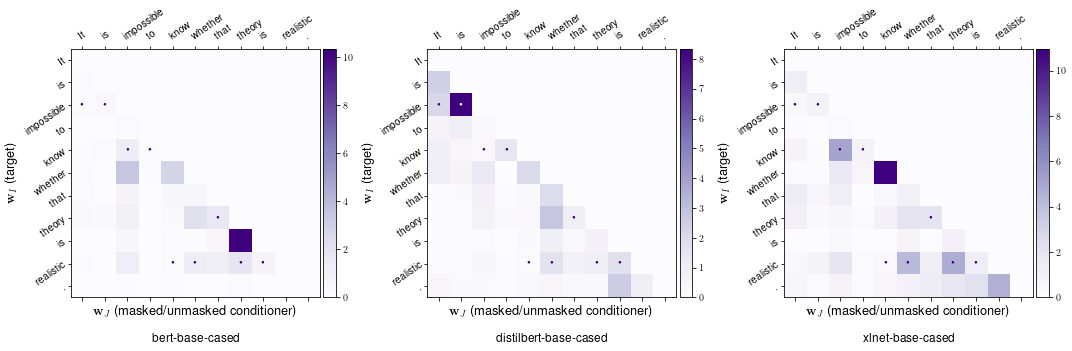

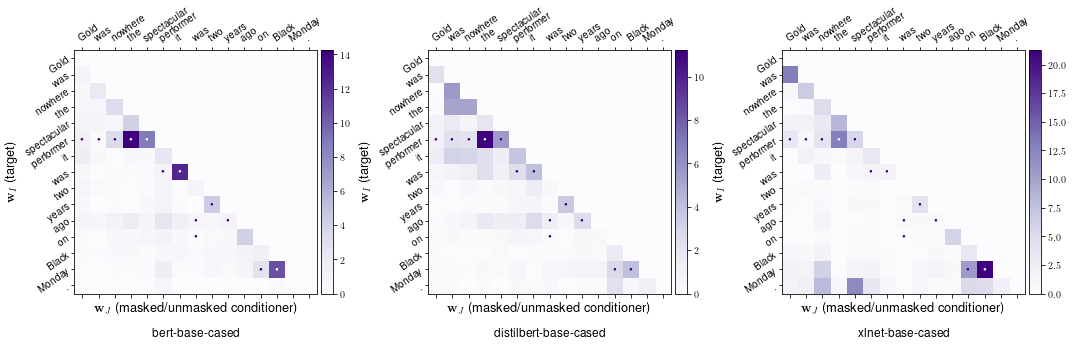

In [302]:
OUTPUTDIR = "figures/"

plot_comparison(
    ['bert-base-cased','distilbert-base-cased','xlnet-base-cased'], 
    MATRICES, [442,1352], OBSERVATIONS,
    save_suffix="ce")

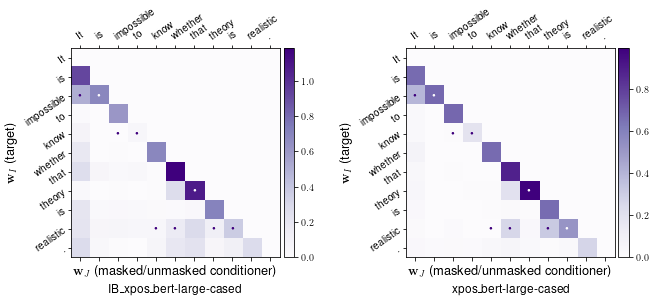

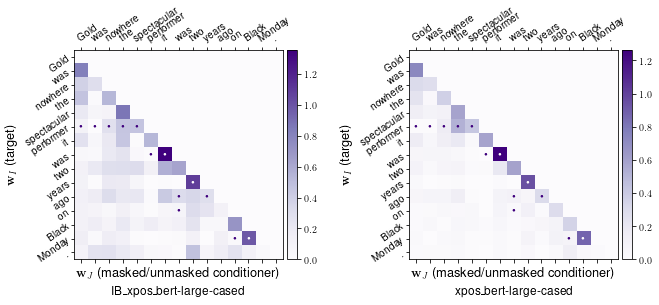

In [310]:
plot_comparison(
    ['IB_xpos_bert-large-cased','xpos_bert-large-cased'],
    POS_MATRICES, [442,1352], OBSERVATIONS,
    save_suffix="pos")

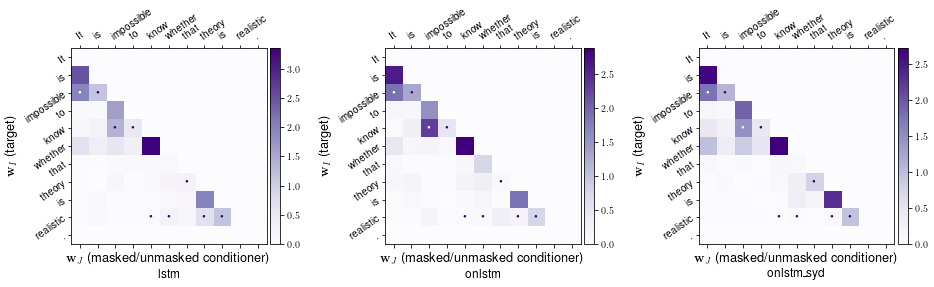

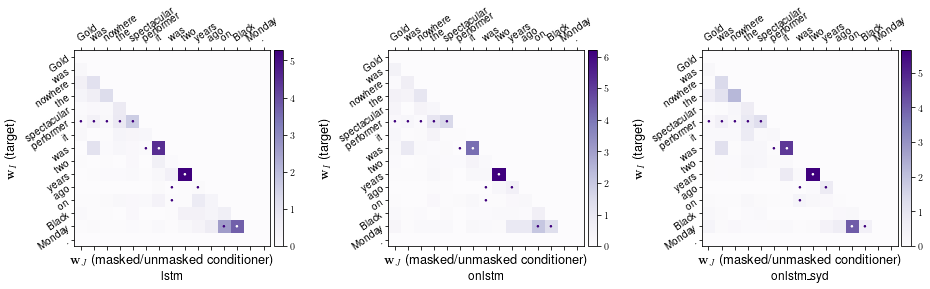

In [311]:
plot_comparison(
    ['lstm', 'onlstm', 'onlstm_syd'], 
    LSTM_MATRICES, [442,1352], OBSERVATIONS,
    save_suffix="lstm")

In [8]:
OBSERVATIONS[1255].sentence

('Source', ':', 'Fulton', 'Prebon', '-LRB-', 'U.S.A', '.', '-RRB-', 'Inc', '.')